# ConvLSTM model

Import libraries and modules.

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

/workspace/FLOOD_group2/models
/workspace/FLOOD_group2


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation
from post_processing.plots import plot_losses

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/multi_conv_lstm_16batch_8hidden_8layers.pth'

# if using a "simple" ConvLSTM model uncomment the following line and comment the one above
# save_path = 'models/ConvLSTM_model/conv_lstm_16batch_32hidden_48layers.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are not stored in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# first position is the samples, second decides between inputs or targets, notice new shape of inputs
train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

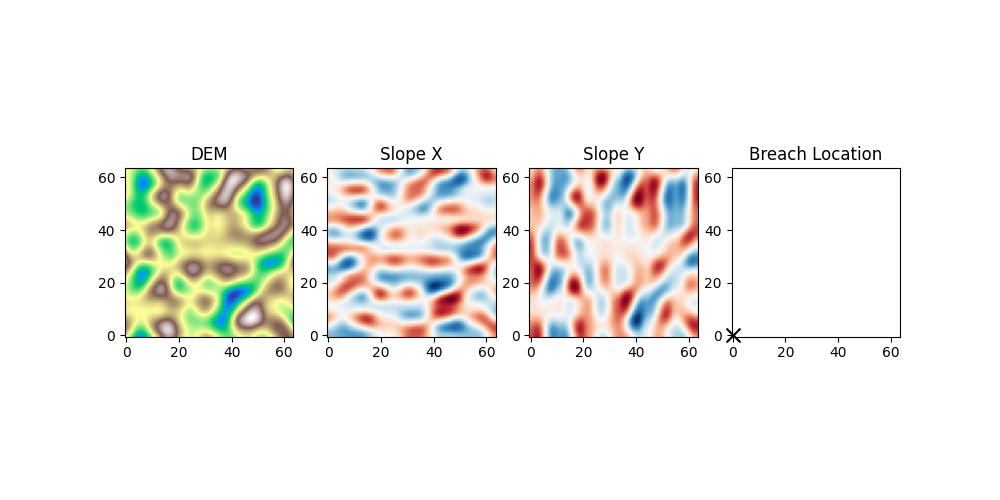

In [8]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0
inputs = train_dataset[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

In [9]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_wd, scaler_q, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_wd, scaler_q, train_val)

In [11]:
print(normalized_val_dataset[0])

(tensor([[[[0.4637, 0.4705, 0.4665,  ..., 0.5035, 0.4901, 0.4707],
          [0.4455, 0.4528, 0.4520,  ..., 0.5170, 0.5083, 0.4910],
          [0.4417, 0.4499, 0.4532,  ..., 0.5308, 0.5295, 0.5169],
          ...,
          [0.4729, 0.4724, 0.4674,  ..., 0.4090, 0.3989, 0.3992],
          [0.4757, 0.4790, 0.4721,  ..., 0.4265, 0.4205, 0.4266],
          [0.4681, 0.4723, 0.4638,  ..., 0.4465, 0.4433, 0.4518]],

         [[0.4610, 0.4625, 0.4701,  ..., 0.5395, 0.5513, 0.5563],
          [0.4790, 0.4806, 0.4897,  ..., 0.5399, 0.5550, 0.5633],
          [0.5158, 0.5178, 0.5286,  ..., 0.5281, 0.5479, 0.5625],
          ...,
          [0.5224, 0.5349, 0.5322,  ..., 0.5298, 0.5404, 0.5579],
          [0.5002, 0.5061, 0.5016,  ..., 0.5526, 0.5612, 0.5713],
          [0.4873, 0.4898, 0.4856,  ..., 0.5557, 0.5626, 0.5684]],

         [[0.5520, 0.5393, 0.5165,  ..., 0.5183, 0.4971, 0.4901],
          [0.5533, 0.5436, 0.5267,  ..., 0.5319, 0.5051, 0.4948],
          [0.5552, 0.5495, 0.5398,  ..., 

In [12]:
print(train_set[0][0].shape)

torch.Size([1, 4, 64, 64])


In [13]:
# Model
model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], 
                          hidden_dim = 32, kernel_size = (3, 3), num_layers = 4, batch_first=True, bias=True, return_all_layers = False).to(device)

# if using a "simple" ConvLSTM model uncomment the following line and comment the ones above
# model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
#                  num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

In [14]:
model
# why are there 4 less cells states in the Conv2D (?) - possible question for the presentation, from Roberto

MultiStepConvLSTM(
  (conv2): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(36, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-3): 3 x ConvLSTMCell(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [15]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # Assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 263234
Model size: 1.00 MB


In [16]:
# Set training parameters
learning_rate = 0.001
batch_size = 8 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
# num_epochs = 3000
num_epochs = 300

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [17]:
train_losses = []
val_losses = []
count = 0
for epoch in range(1, num_epochs+1):
    # print(f"epoch number: {epoch}")
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    if epoch%100 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    if count > 300:
        print(f"Loss Stagnated for 300 epochs, early stopping initiated")
        break

KeyboardInterrupt: 

In [18]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

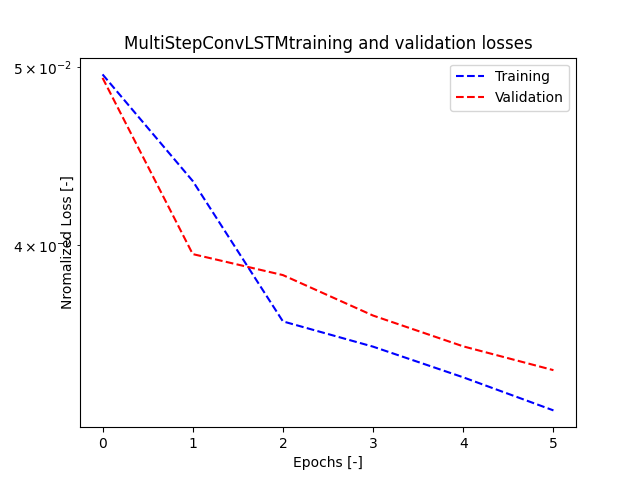

In [19]:
plot_losses(train_losses, val_losses, 'MultiStepConvLSTM')

In [20]:
normalized_train_dataset[0][1][-1,0].shape

torch.Size([64, 64])

In [21]:
normalized_train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

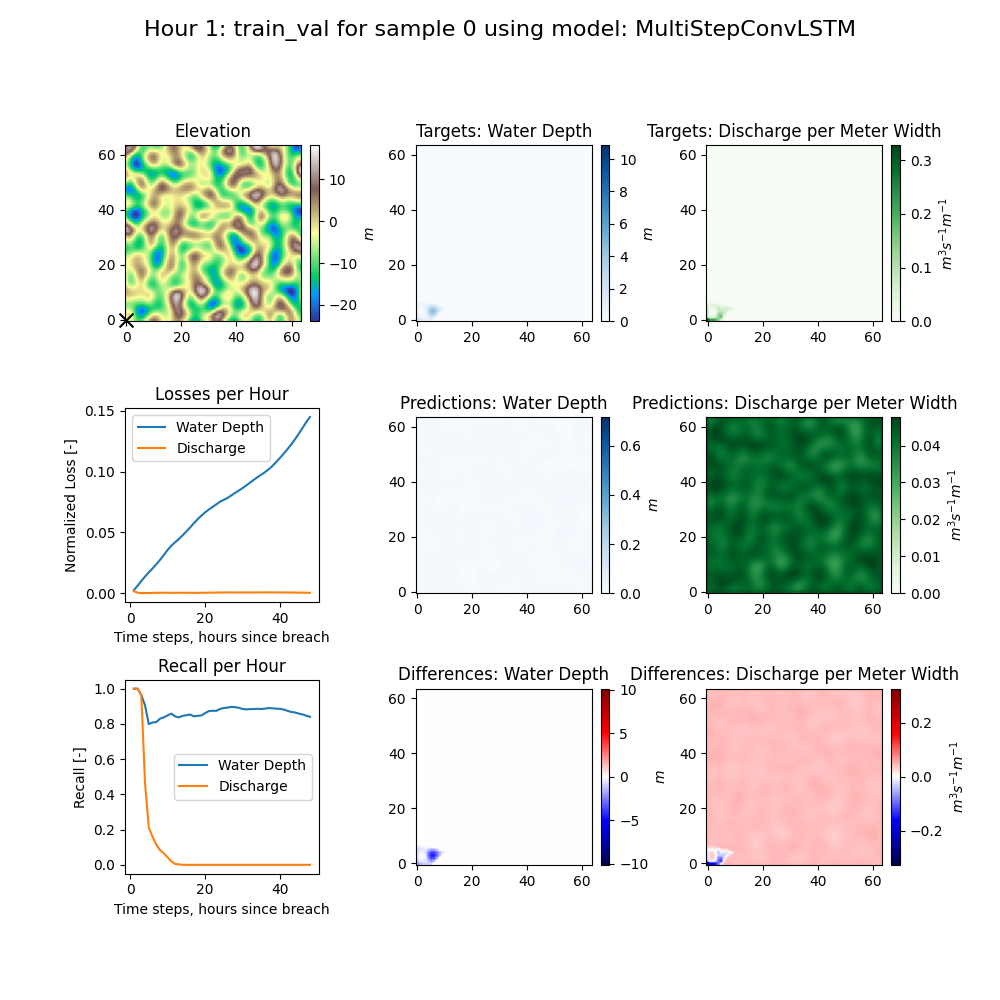

In [26]:
plot_animation(0, train_set, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)